In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib # Thêm thư viện để lưu model
import os     # Thêm thư viện để quản lý đường dẫn, thư mục

In [4]:
df_original = pd.read_csv(r'E:\LEARN_5\XuLyNgonNguTuNhien\project\data\cleaned_data.csv')
df = df_original.copy()
print("5 dòng dữ liệu đầu tiên (gốc):")
print(df.head())
df.dropna(subset=['text', 'Topic'], inplace=True)
print(f"\nSố lượng mẫu sau khi loại bỏ NaN: {len(df)}")

5 dòng dữ liệu đầu tiên (gốc):
                                                text Topic
0  công_cụ trí_tuệ_nhân_tạo hữu_dụng chatgpt cạnh...    AI
1  figure_trí tuệ nhân_tạo công_ty robot hình mỹ ...    AI
2  ceo microsoft trí_tuệ_nhân_tạo đảm_nhiệm viết ...    AI
3  trí_tuệ_nhân_tạo grok musk trả_lời internet el...    AI
4  openai xác_nhận chatgpt nịnh_hót openai chatgp...    AI

Số lượng mẫu sau khi loại bỏ NaN: 16003



--- Phân tích số lượng mẫu theo chủ đề ---
Số lượng mẫu theo chủ đề TRƯỚC KHI lọc thủ công:
Topic
Giáo dục 4.0               449
Người Việt 5 châu          448
Giải trí giới sao          444
Việc làm                   443
Tin tức sức khoẻ           443
Giải trí nhạc              441
Giải trí phim              440
Ebank                      440
Dân sinh                   439
Sống khoẻ                  439
Bóng đá                    438
Giao thông                 438
Chính trị                  437
Các môn thể thao khác      436
Quân sự                    434
Hậu trường thể thao        432
Kinh doanh quốc tế         430
Nhịp sống                  428
AI                         428
Thiết bị                   427
Giải trí thời trang        426
Vũ trụ                     422
Tin tức Giáo dục           421
Sân khấu mỹ thuật          419
Chuyển đổi số              417
Thị trường xe              416
Hàng hóa                   414
Ẩm thực                    404
Tổ ấm                      404
Ch

C:\Users\Mai Xuan Truong\AppData\Local\Temp\ipykernel_2756\4001366875.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")


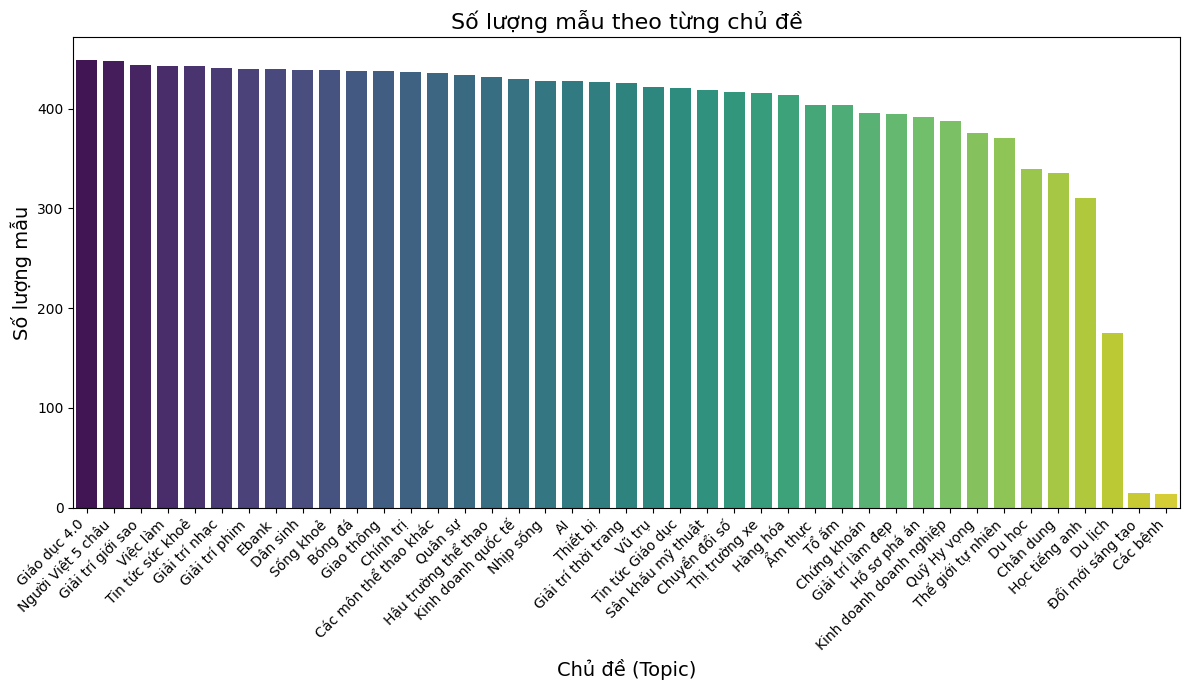

In [5]:
# --- 1.1. Phân tích số lượng mẫu theo chủ đề và cho phép loại bỏ thủ công ---
print("\n--- Phân tích số lượng mẫu theo chủ đề ---")
topic_counts = df['Topic'].value_counts()
print("Số lượng mẫu theo chủ đề TRƯỚC KHI lọc thủ công:")
print(topic_counts)

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 7)) # Tăng kích thước để dễ nhìn hơn
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.title('Số lượng mẫu theo từng chủ đề', fontsize=16)
plt.xlabel('Chủ đề (Topic)', fontsize=14)
plt.ylabel('Số lượng mẫu', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10) # Xoay nhãn trục x cho dễ đọc
plt.yticks(fontsize=10)
plt.tight_layout() # Tự động điều chỉnh để các thành phần không bị đè lên nhau
plt.show()

In [6]:
TOPICS_TO_REMOVE = ["Du lịch", "Đổi mới sáng tạo", "Các bệnh"]

In [7]:
df_filtered = df.copy() # Bắt đầu với tất cả dữ liệu
if TOPICS_TO_REMOVE:
    print(f"\nCác chủ đề được chọn để loại bỏ thủ công: {', '.join(TOPICS_TO_REMOVE)}")
    # Kiểm tra xem các chủ đề cần loại bỏ có thực sự tồn tại trong dữ liệu không
    actual_topics_to_remove = [topic for topic in TOPICS_TO_REMOVE if topic in df_filtered['Topic'].unique()]
    if not actual_topics_to_remove:
        print("Không có chủ đề nào trong danh sách cần loại bỏ tồn tại trong dữ liệu hiện tại.")
    else:
        print(f"Các chủ đề thực sự sẽ bị loại bỏ: {', '.join(actual_topics_to_remove)}")
        df_filtered = df_filtered[~df_filtered['Topic'].isin(actual_topics_to_remove)].copy()
        removed_count_manual = len(df) - len(df_filtered)
        print(f"Đã loại bỏ {removed_count_manual} mẫu thuộc các chủ đề trên.")
else:
    print("\nKhông có chủ đề nào được chọn để loại bỏ thủ công.")

print("\nSố lượng mẫu theo chủ đề SAU KHI lọc thủ công:")
if not df_filtered.empty:
    print(df_filtered['Topic'].value_counts())
    print(f"Tổng số lượng mẫu còn lại: {len(df_filtered)}")
else:
    print("Không còn mẫu nào sau khi lọc chủ đề.")

# Kiểm tra nếu không còn đủ dữ liệu hoặc chủ đề để tiếp tục
if df_filtered.empty:
    print("\nKhông còn dữ liệu sau khi lọc chủ đề. Dừng chương trình.")
    exit()
if df_filtered['Topic'].nunique() < 2:
    print(f"\nChỉ còn {df_filtered['Topic'].nunique()} chủ đề sau khi lọc. Cần ít nhất 2 chủ đề để phân loại. Dừng chương trình.")
    exit()

df = df_filtered # Cập nhật DataFrame để sử dụng từ đây về sau


Các chủ đề được chọn để loại bỏ thủ công: Du lịch, Đổi mới sáng tạo, Các bệnh
Các chủ đề thực sự sẽ bị loại bỏ: Du lịch, Đổi mới sáng tạo, Các bệnh
Đã loại bỏ 204 mẫu thuộc các chủ đề trên.

Số lượng mẫu theo chủ đề SAU KHI lọc thủ công:
Topic
Giáo dục 4.0               449
Người Việt 5 châu          448
Giải trí giới sao          444
Việc làm                   443
Tin tức sức khoẻ           443
Giải trí nhạc              441
Giải trí phim              440
Ebank                      440
Sống khoẻ                  439
Dân sinh                   439
Giao thông                 438
Bóng đá                    438
Chính trị                  437
Các môn thể thao khác      436
Quân sự                    434
Hậu trường thể thao        432
Kinh doanh quốc tế         430
Nhịp sống                  428
AI                         428
Thiết bị                   427
Giải trí thời trang        426
Vũ trụ                     422
Tin tức Giáo dục           421
Sân khấu mỹ thuật          419
Chuyển đổi 

In [8]:
# --- 1.2. Xáo trộn (Shuffle) dữ liệu ---
print("\n--- Xáo trộn dữ liệu ---")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("5 dòng dữ liệu đầu tiên SAU KHI xáo trộn:")
print(df.head())


--- Xáo trộn dữ liệu ---
5 dòng dữ liệu đầu tiên SAU KHI xáo trộn:
                                                text                  Topic
0  trường hàng_đầu khoa_học dữ_liệu trí_tuệ_nhân_...                 Du học
1  chatgpt dạy ngoại_ngữ openai tung demo thể_hiệ...                     AI
2  bốn tiết_kiệm chi_phí du_học australia du_học_...                 Du học
3  chocolate nguy_cơ tiểu_đường thai kỳ thai tuần...              Sống khoẻ
4  hc vàng asiad philippines hai dính doping phil...  Các môn thể thao khác


In [9]:
# --- 2. Chia dữ liệu thành tập huấn luyện và tập kiểm thử ---
X = df['text']
y = df['Topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nKích thước tập huấn luyện: {len(X_train)}")
print(f"Kích thước tập kiểm thử: {len(X_test)}")
print("Phân phối chủ đề trong tập huấn luyện (%):")
print(y_train.value_counts(normalize=True).round(2))
print("Phân phối chủ đề trong tập kiểm thử (%):")
print(y_test.value_counts(normalize=True).round(2))


Kích thước tập huấn luyện: 12639
Kích thước tập kiểm thử: 3160
Phân phối chủ đề trong tập huấn luyện (%):
Topic
Giáo dục 4.0               0.03
Người Việt 5 châu          0.03
Giải trí giới sao          0.03
Tin tức sức khoẻ           0.03
Việc làm                   0.03
Giải trí nhạc              0.03
Giải trí phim              0.03
Ebank                      0.03
Sống khoẻ                  0.03
Dân sinh                   0.03
Giao thông                 0.03
Bóng đá                    0.03
Chính trị                  0.03
Các môn thể thao khác      0.03
Quân sự                    0.03
Hậu trường thể thao        0.03
Kinh doanh quốc tế         0.03
Nhịp sống                  0.03
Thiết bị                   0.03
AI                         0.03
Giải trí thời trang        0.03
Vũ trụ                     0.03
Tin tức Giáo dục           0.03
Sân khấu mỹ thuật          0.03
Chuyển đổi số              0.03
Thị trường xe              0.03
Hàng hóa                   0.03
Ẩm thực                

In [10]:
# --- 3. Vector hóa văn bản sử dụng TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nKích thước ma trận TF-IDF của tập huấn luyện: {X_train_tfidf.shape}")
print(f"Kích thước ma trận TF-IDF của tập kiểm thử: {X_test_tfidf.shape}")

labels = sorted(y.unique())


Kích thước ma trận TF-IDF của tập huấn luyện: (12639, 5000)
Kích thước ma trận TF-IDF của tập kiểm thử: (3160, 5000)


In [11]:
# --- 4. Huấn luyện và Đánh giá Mô hình Multinomial Naive Bayes ---
print("\n--- Mô hình Multinomial Naive Bayes ---")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Độ chính xác (Accuracy): {accuracy_nb:.4f}")
print("Báo cáo phân loại (Classification Report):")
print(classification_report(y_test, y_pred_nb, labels=labels, zero_division=0, target_names=labels if labels else None))
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)


--- Mô hình Multinomial Naive Bayes ---
Độ chính xác (Accuracy): 0.8500
Báo cáo phân loại (Classification Report):
                         precision    recall  f1-score   support

                     AI       0.77      0.87      0.82        86
                Bóng đá       0.83      0.95      0.89        88
          Chuyển đổi số       0.88      0.52      0.65        83
              Chân dung       0.78      0.88      0.83        67
              Chính trị       0.89      0.95      0.92        87
            Chứng khoán       0.92      0.90      0.91        79
  Các môn thể thao khác       0.87      0.93      0.90        87
                 Du học       0.90      0.78      0.83        68
               Dân sinh       0.78      0.76      0.77        88
                  Ebank       0.87      0.90      0.88        88
             Giao thông       0.82      0.97      0.89        88
           Giáo dục 4.0       0.77      0.92      0.84        90
      Giải trí giới sao       0.81    

In [12]:
# --- 5. Huấn luyện và Đánh giá Mô hình Logistic Regression ---
print("\n--- Mô hình Logistic Regression ---")
lr_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Độ chính xác (Accuracy): {accuracy_lr:.4f}")
print("Báo cáo phân loại (Classification Report):")
print(classification_report(y_test, y_pred_lr, labels=labels, zero_division=0, target_names=labels if labels else None))
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)


--- Mô hình Logistic Regression ---
Độ chính xác (Accuracy): 0.8756
Báo cáo phân loại (Classification Report):
                         precision    recall  f1-score   support

                     AI       0.85      0.90      0.87        86
                Bóng đá       0.88      0.91      0.89        88
          Chuyển đổi số       0.79      0.72      0.75        83
              Chân dung       0.87      0.91      0.89        67
              Chính trị       0.89      0.95      0.92        87
            Chứng khoán       0.95      0.87      0.91        79
  Các môn thể thao khác       0.86      0.93      0.90        87
                 Du học       0.89      0.82      0.85        68
               Dân sinh       0.80      0.88      0.84        88
                  Ebank       0.92      0.91      0.91        88
             Giao thông       0.86      0.92      0.89        88
           Giáo dục 4.0       0.93      0.89      0.91        90
      Giải trí giới sao       0.83      0.

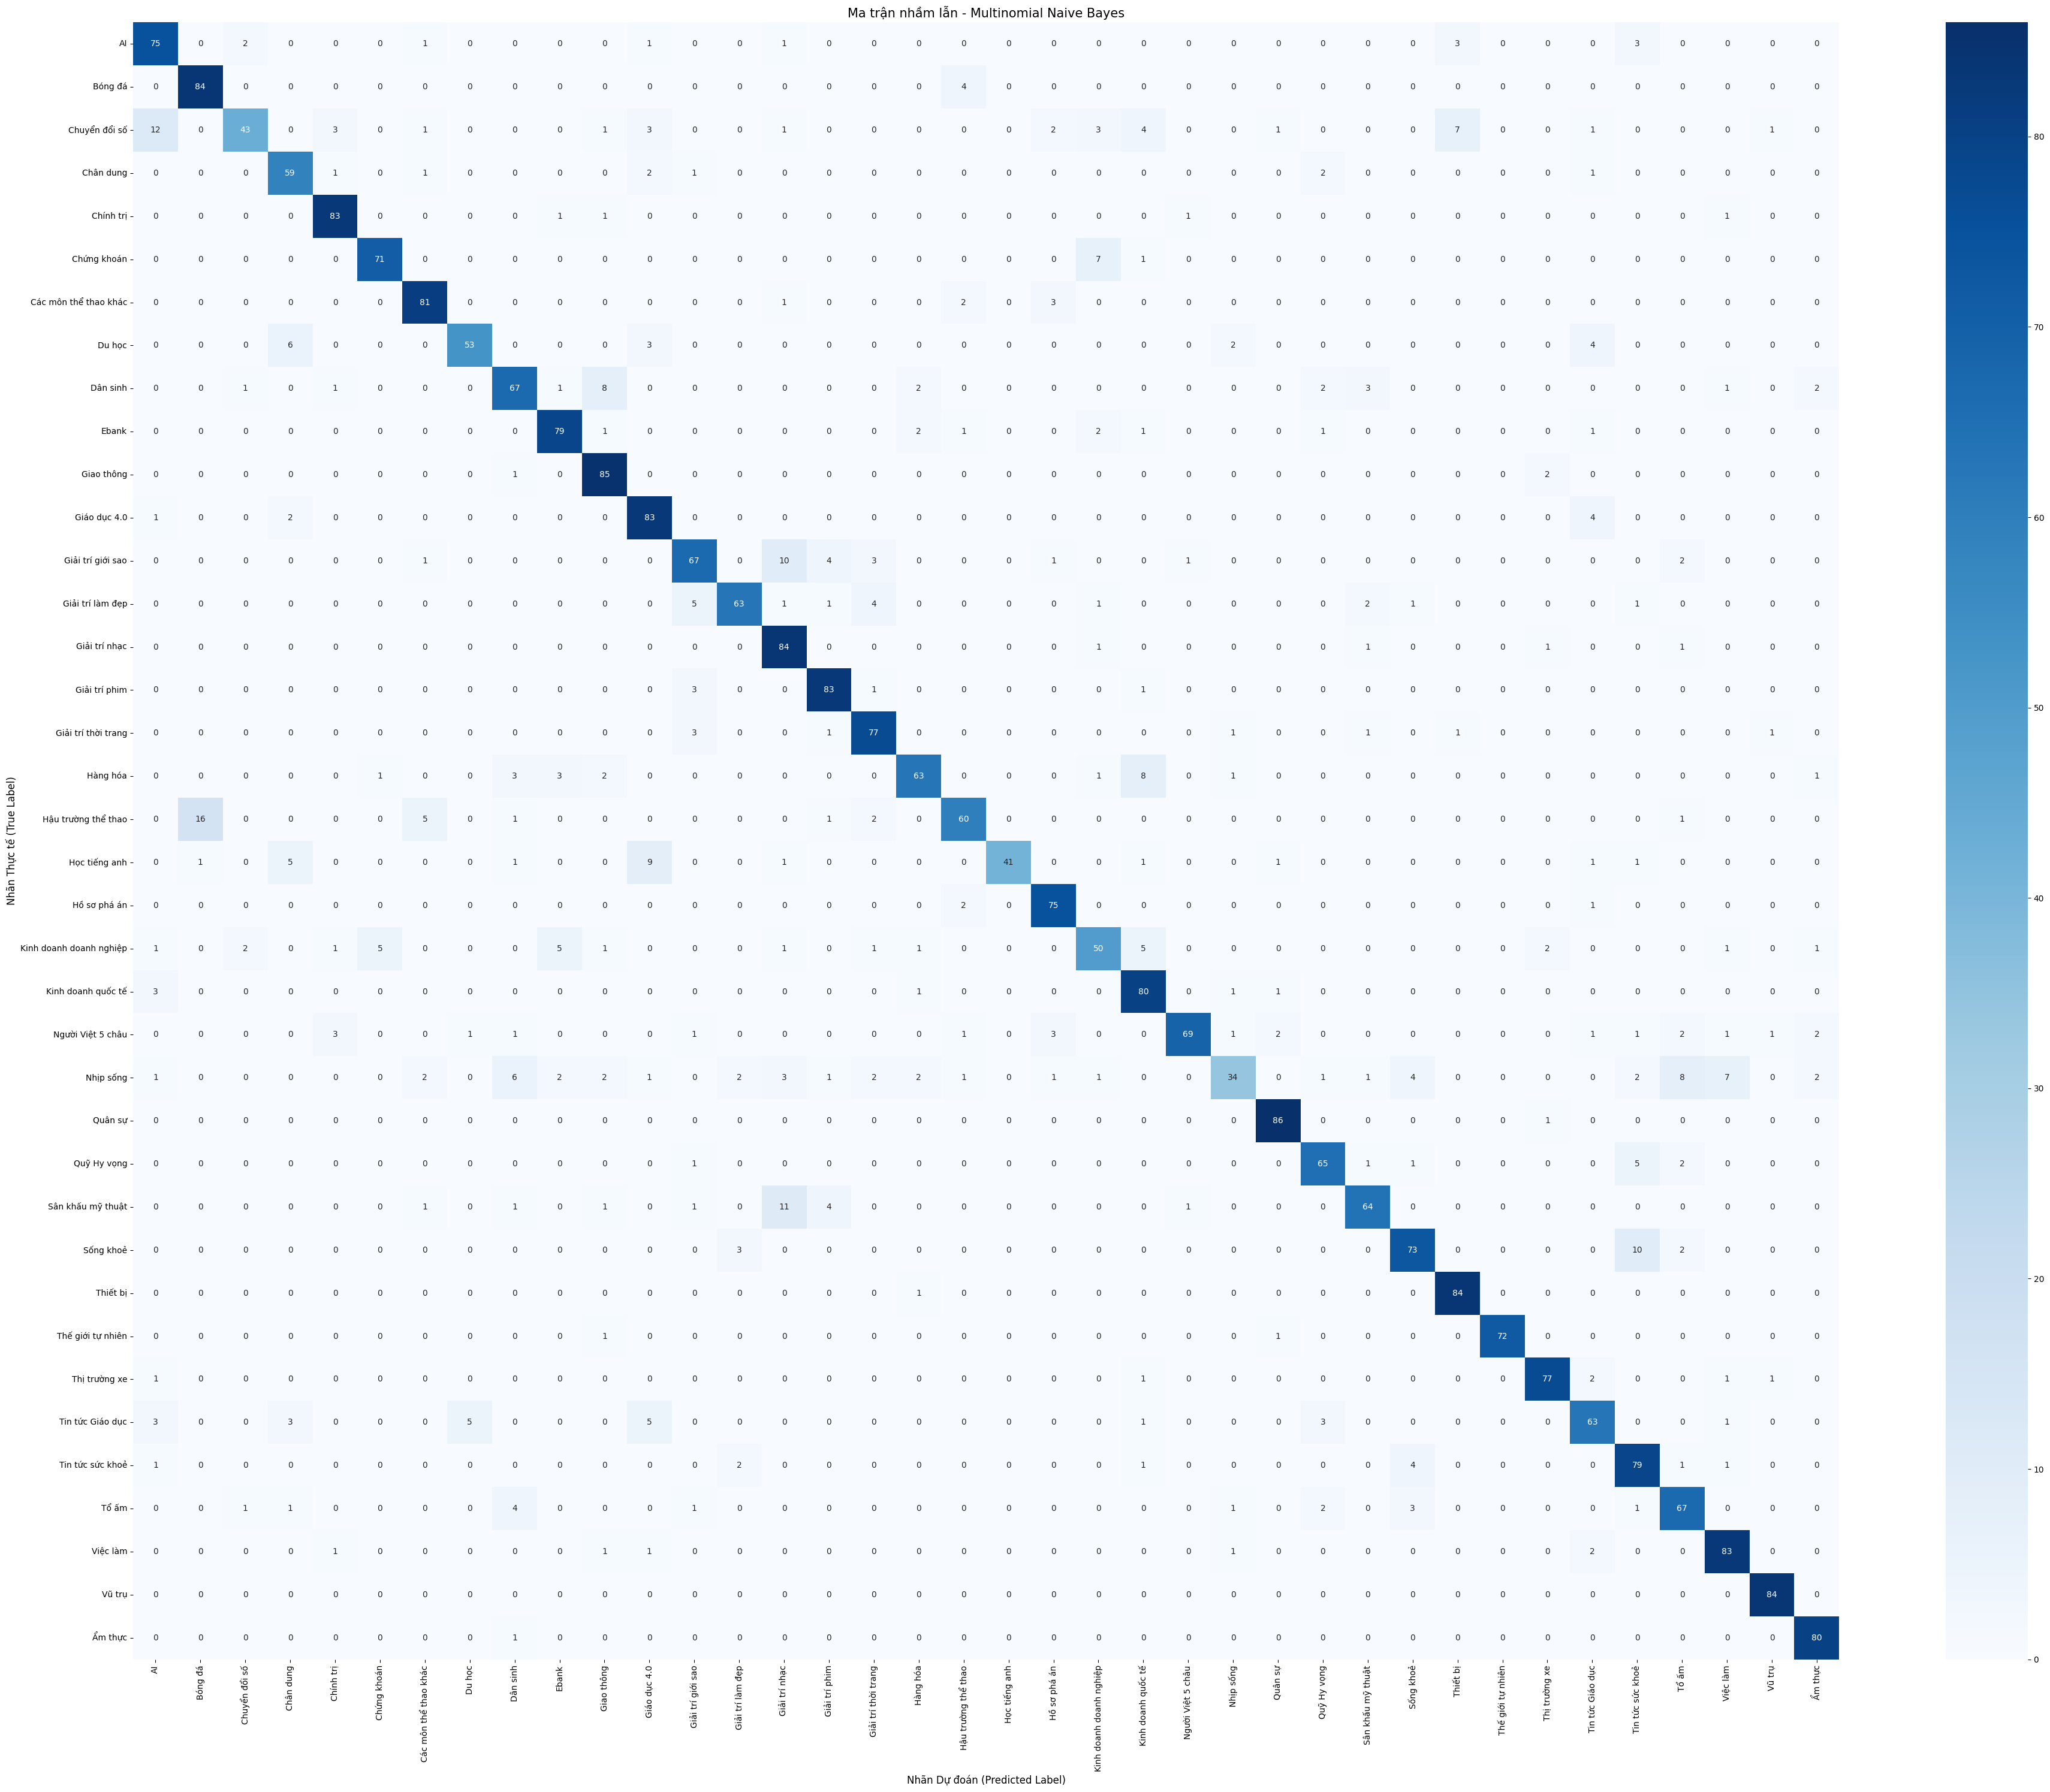

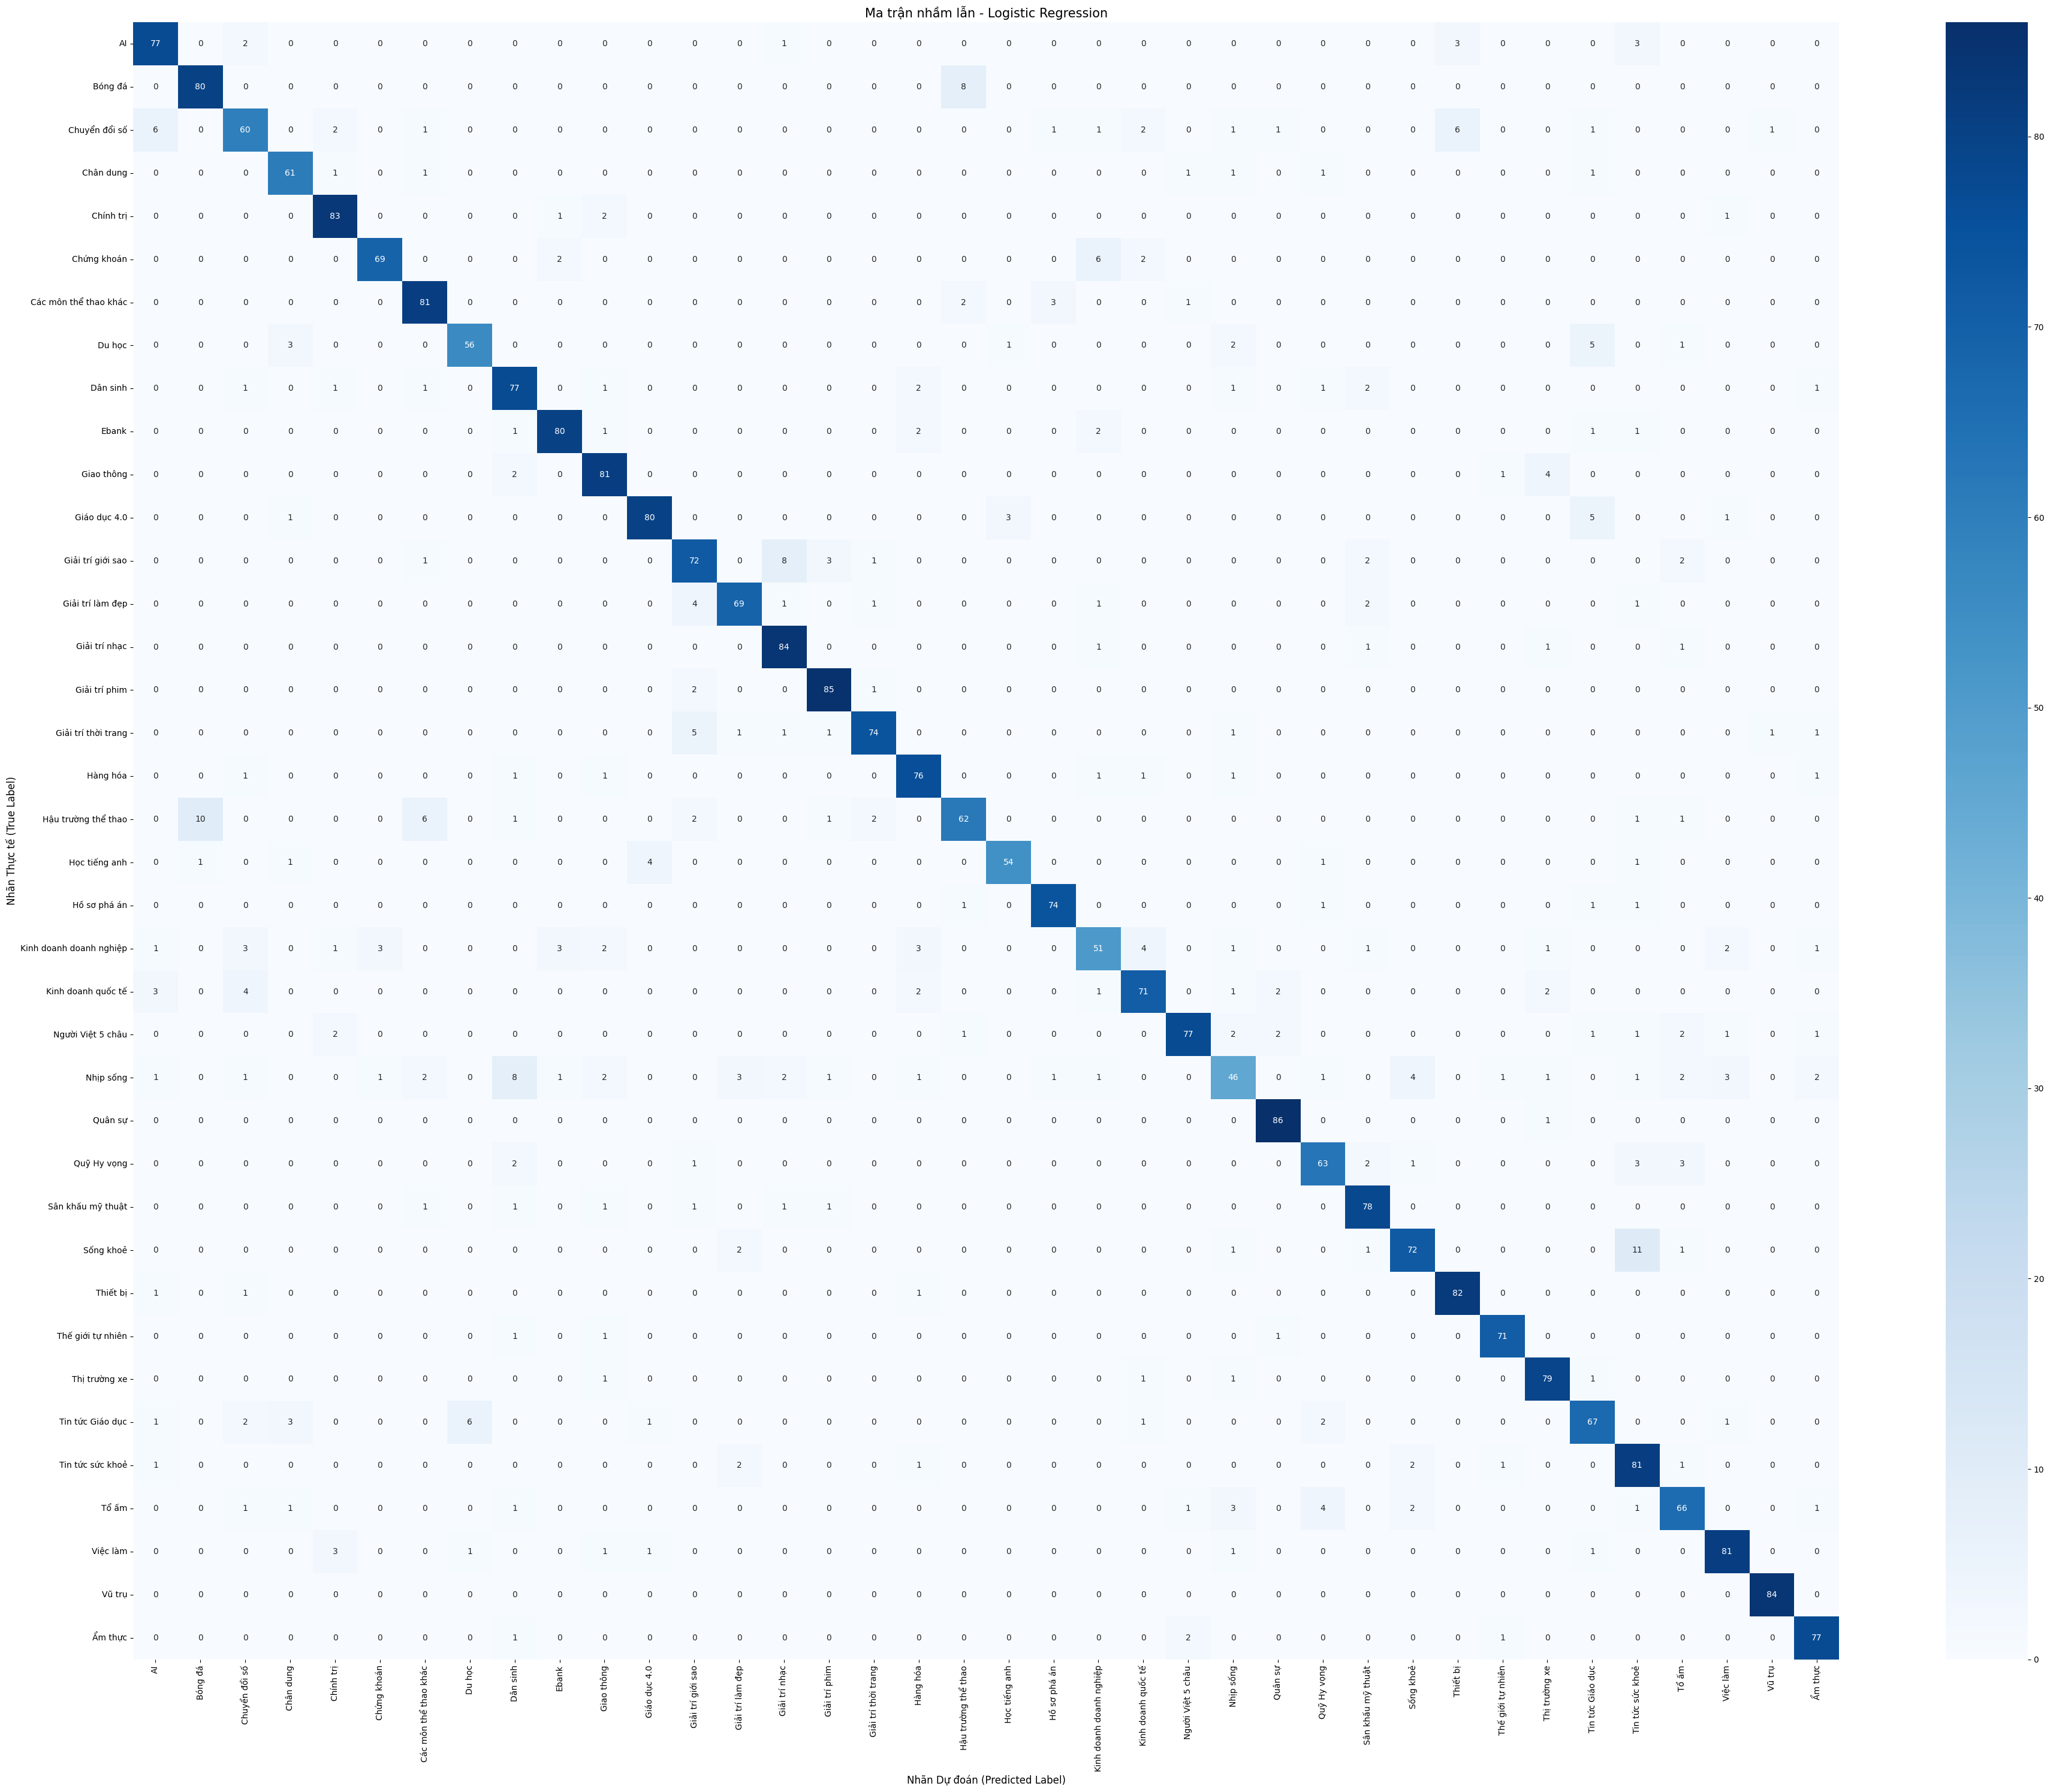

In [13]:
# --- 6. Trực quan hóa Ma trận nhầm lẫn ---
def plot_confusion_matrix(cm, classes, title):
    if not classes: # Kiểm tra nếu danh sách classes rỗng
        print(f"Không thể vẽ ma trận nhầm lẫn cho '{title}' vì không có nhãn nào được cung cấp.")
        return
    plt.figure(figsize=(max(6, len(classes)), max(4, int(len(classes)*0.8))))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=15)
    plt.ylabel('Nhãn Thực tế (True Label)', fontsize=12)
    plt.xlabel('Nhãn Dự đoán (Predicted Label)', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

if len(y_test) > 0 and labels: # Kiểm tra labels không rỗng
    plot_confusion_matrix(cm_nb, labels, 'Ma trận nhầm lẫn - Multinomial Naive Bayes')
    plot_confusion_matrix(cm_lr, labels, 'Ma trận nhầm lẫn - Logistic Regression')
else:
    print("\nKhông đủ dữ liệu trong tập kiểm thử hoặc không có nhãn hợp lệ để vẽ ma trận nhầm lẫn.")

In [14]:
# --- 7. LƯU MÔ HÌNH VÀ TFIDF VECTORIZER ---
MODEL_DIR = r'E:\LEARN_5\XuLyNgonNguTuNhien\project\models'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Đã tạo thư mục: {MODEL_DIR}")

tfidf_vectorizer_path = os.path.join(MODEL_DIR, 'tfidf_vectorizer.joblib')
nb_model_path = os.path.join(MODEL_DIR, 'naive_bayes_model.joblib')
lr_model_path = os.path.join(MODEL_DIR, 'logistic_regression_model.joblib')

# Lưu TF-IDF Vectorizer
try:
    if hasattr(tfidf_vectorizer, 'vocabulary_') and tfidf_vectorizer.vocabulary_:
        joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)
        print(f"TF-IDF Vectorizer đã được lưu vào: {tfidf_vectorizer_path}")
    else:
        print("Lỗi: TF-IDF Vectorizer chưa được fit hoặc rỗng, không thể lưu.")
except Exception as e:
    print(f"Lỗi khi lưu TF-IDF Vectorizer: {e}")

# Lưu mô hình Naive Bayes
try:
    if hasattr(nb_model, 'classes_') and len(nb_model.classes_) > 0:
        joblib.dump(nb_model, nb_model_path)
        print(f"Mô hình Naive Bayes đã được lưu vào: {nb_model_path}")
    else:
        print("Lỗi: Mô hình Naive Bayes chưa được huấn luyện hoặc rỗng, không thể lưu.")
except Exception as e:
    print(f"Lỗi khi lưu mô hình Naive Bayes: {e}")

# Lưu mô hình Logistic Regression
try:
    if hasattr(lr_model, 'classes_') and len(lr_model.classes_) > 0:
        joblib.dump(lr_model, lr_model_path)
        print(f"Mô hình Logistic Regression đã được lưu vào: {lr_model_path}")
    else:
        print("Lỗi: Mô hình Logistic Regression chưa được huấn luyện hoặc rỗng, không thể lưu.")
except Exception as e:
    print(f"Lỗi khi lưu mô hình Logistic Regression: {e}")

print("\n--- Quá trình huấn luyện và lưu mô hình hoàn tất! ---")

TF-IDF Vectorizer đã được lưu vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models\tfidf_vectorizer.joblib
Mô hình Naive Bayes đã được lưu vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models\naive_bayes_model.joblib
Mô hình Logistic Regression đã được lưu vào: E:\LEARN_5\XuLyNgonNguTuNhien\project\models\logistic_regression_model.joblib

--- Quá trình huấn luyện và lưu mô hình hoàn tất! ---


In [15]:
from text_cleaner import TextCleaner

In [16]:
# Đường dẫn đến các file stopwords và abbreviations
stopwords_file = 'E:\\LEARN_5\\XuLyNgonNguTuNhien\\project\\crawl\\stopwords.txt'
abbreviations_file = 'E:\\LEARN_5\\XuLyNgonNguTuNhien\\project\\crawl\\acronym.txt'
vncorenlp_model_dir = 'E:/LEARN_5/XuLyNgonNguTuNhien/vncorenlp'

# Tạo instance của TextCleaner
if 'cleaner' not in globals():
	cleaner = TextCleaner(stopwords_file, abbreviations_file, vncorenlp_model_dir)
else:
	print("Instance of TextCleaner already exists. Skipping initialization.")

In [26]:
# Dữ liệu mẫu
title = "Các ông lớn công nghệ giữa ngã ba đường vì AI"
description = "Các hãng công nghệ hàng đầu như Apple, Facebook, Google được đánh giá bắt đầu loay hoay tìm cách thay đổi trong bối cảnh AI phát triển thần tốc."
content = "AI đang được coi là \"kẻ quấy phá\" ở Thung lũng Silicon, đặc biệt với các tập đoàn lâu đời như Apple (49 năm), Google (26 năm), Meta (21 năm) hay Amazon (31 năm) \"Công bằng mà nói, chưa Big Tech nào gặp khó khăn. Họ vẫn là trụ cột của nước Mỹ với tổng vốn hóa thị trường trên 7.000 tỷ USD\", WSJ bình luận. \"Tuy nhiên, họ đều đang cùng nhau đứng ở ngã ba đường và tiến thoái lưỡng nan, điều cuốn sách kinh doanh kinh điển The Innovator's Dilemma từng đề cập\" \"The Innovator's Dilemma (Thách thức sáng tạo) của tác giả Clayton Christensen giải thích cách các sản phẩm, dịch vụ mới \"lật đổ\" cái cũ. Cuốn sách nhắc đến thuật ngữ disruption, ý nói các công ty lớn và thành công có thể thất bại trước sự xuất hiện công ty nhỏ sở hữu công nghệ, quy trình đột phá. Giống như Internet từng \"thanh lọc\" nhiều doanh nghiệp truyền thống, AI cũng có thể khiến các ông lớn công nghệ hiện nay phải thay đổi hoặc chung số phận\" \"Theo Bloomberg, tại phiên tòa chống độc quyền của Bộ Tư pháp đối với Google tuần trước, Eddy Cue, Phó chủ tịch mảng dịch vụ của Apple, cho biết lượng truy vấn tìm kiếm của Google trên thiết bị công ty lần đầu tiên giảm sau 20 năm vào tháng trước. Dù Google phủ nhận, CNN nhận định tiết lộ của Eddy Cue cho thấy người dùng đang dần chuyển sang hỏi đáp thông tin bằng chatbot AI. Năm ngoái, công ty nghiên cứu thị trường Gartner ước tính tìm kiếm trực tuyến kiểu truyền thông sẽ giảm 25% vào năm 2026 do AI trở nên thịnh hành\" \"CEO Apple Tim Cook cũng đang phải trấn an nhà đầu tư trước sự chậm trễ triển khai AI trên iPhone. \"Chúng tôi cần thêm thời gian để hoàn thành đúng theo tiêu chuẩn chất lượng cao nhất\", ông nói trong cuộc họp trước giới đầu tư tuần trước về Apple Intelligence\" \"Trong khi đó, Mark Zuckerberg, CEO Meta, cho biết người dùng đang giảm việc chia sẻ với bạn bè trên Facebook. Theo giới chuyên gia, điều này một phần do mạng xã hội hơn 20 năm tuổi trở nên \"già cỗi\" trước sự mới mẻ của TikTok với thuật toán AI đề xuất nội dung\" \"Một số đã triển khai giải pháp riêng, như Meta tung ra chatbot Meta AI, Google có mô hình Gemini còn Microsoft phát triển Copilot. Tuy nhiên, chưa ai tìm ra \"công thức chiến thắng\". Họ đang ở ngã ba đường: có quy mô quá lớn, không thể xóa bỏ hoàn toàn mô hình cũ để mạnh dạn thử nghiệm những thứ mới mẻ như các startup nhỏ\" \"Bạn không thể gắn bó với một khuôn khổ hoạt động hoặc một cách làm cụ thể nào đó trong thời AI\", Karl Mozurkewich, kiến trúc sư trưởng tại công ty điện toán đám mây Valdi, viết trên blog\" \"Điều này mang lại hy vọng cho những người như Sarah Guo, nhà đầu tư mạo hiểm trẻ ở Thung lũng Silicon. Cô đang tìm kiếm startup AI hấp dẫn tiếp theo - những công ty có thể hạ bệ ông lớn. \"Với công ty đã thành danh, việc sáng tạo sản phẩm mới sẽ đầy rủi ro\", Guo nói trong podcast Bold Names phát sóng tuần trước\" \"Đây là điều tôi thích nhất về AI\", Theo Brown, nhà phát triển Ping, nói. \"Nó biến những thứ trước đây ngành công nghệ coi là siêu giá trị và thiêng liêng thành thứ cực kỳ rẻ và dễ vứt bỏ\" \"Không phải hãng công nghệ lớn nào cũng bị tác động theo hướng tiêu cực. Nvidia, ra đời cách đây 32 năm, phát triển bùng nổ nhờ cơn khát GPU dùng để huấn luyện AI. Tuy nhiên, sự xuất hiện của các mô hình giá rẻ như DeepSeek cũng đặt ra câu hỏi liệu có cần đầu tư quá nhiều tiền vào chip AI như hiện nay\" \"Tất cả đang trong tình huống tiến thoái lưỡng nan, dù chưa có ai thực sự gặp khủng hoảng\", WSJ bình luận."

In [27]:
# Làm sạch dữ liệu
title_cleaned, description_cleaned, content_cleaned = cleaner.process_text(title, description, content)

In [28]:
text = title_cleaned + " " + description_cleaned + " " + content_cleaned
text

'công_nghệ ngã đường trí_tuệ_nhân_tạo hãng công_nghệ hàng_đầu apple facebook google loay_hoay bối_cảnh trí_tuệ_nhân_tạo phát_triển thần_tốc trí_tuệ_nhân_tạo coi kẻ quấy_phá thung_lũng silicon tập_đoàn lâu_đời apple google meta amazon công_bằng big_tech trụ_cột mỹ tổng vốn hoá thị_trường tỷ đô_la mỹ wsj bình_luận đứng ngã đường tiến_thoái_lưỡng_nan sách kinh_doanh kinh_điển the_innovators_dilemma đề_cập the_innovators_dilemma_thách_thức sáng_tạo tác_giả clayton_christensen giải_thích sản_phẩm dịch_vụ lật_đổ cũ sách nhắc thuật_ngữ disruption công_ty thành_công thất_bại công_ty sở_hữu công_nghệ quy_trình đột_phá internet thanh_lọc doanh_nghiệp truyền_thống trí_tuệ_nhân_tạo công_nghệ số_phận bloomberg phiên_toà chống độc_quyền tư_pháp google tuần eddy_cue phó chủ_tịch mảng dịch_vụ apple truy_vấn tìm_kiếm google thiết_bị công_ty google phủ_nhận cnn nhận_định tiết_lộ eddy_cue dần hỏi_đáp thông_tin chatbot trí_tuệ_nhân_tạo năm_ngoái công_ty nghiên_cứu thị_trường gartner ước_tính tìm_kiếm trực

In [29]:
# --- 7. Ví dụ dự đoán một văn bản mới (Tùy chọn) ---
def predict_new_text(text_input, vectorizer, model, model_name):
    print(f"\n--- Dự đoán với {model_name} cho văn bản mới ---")
    print(f"Văn bản: \"{text_input}\"")
    text_tfidf = vectorizer.transform([text_input])
    prediction = model.predict(text_tfidf)

    if hasattr(model, "predict_proba") and hasattr(model, "classes_"):
        prediction_proba = model.predict_proba(text_tfidf)
        print(f"Chủ đề dự đoán: {prediction[0]}")
        print("Xác suất dự đoán cho từng chủ đề:")
        for i, topic_class in enumerate(model.classes_):
            print(f"  - {topic_class}: {prediction_proba[0][i]:.4f}")
    else:
        print(f"Chủ đề dự đoán: {prediction[0]}")


if X_train_tfidf.shape[0] > 0:
    predict_new_text(text, tfidf_vectorizer, nb_model, "Naive Bayes")
    predict_new_text(text, tfidf_vectorizer, lr_model, "Logistic Regression")

    # predict_new_text(new_article_2, tfidf_vectorizer, nb_model, "Naive Bayes")
    # predict_new_text(new_article_2, tfidf_vectorizer, lr_model, "Logistic Regression")
else:
    print("\nKhông thể thực hiện dự đoán văn bản mới do mô hình chưa được huấn luyện.")


--- Dự đoán với Naive Bayes cho văn bản mới ---
Văn bản: "công_nghệ ngã đường trí_tuệ_nhân_tạo hãng công_nghệ hàng_đầu apple facebook google loay_hoay bối_cảnh trí_tuệ_nhân_tạo phát_triển thần_tốc trí_tuệ_nhân_tạo coi kẻ quấy_phá thung_lũng silicon tập_đoàn lâu_đời apple google meta amazon công_bằng big_tech trụ_cột mỹ tổng vốn hoá thị_trường tỷ đô_la mỹ wsj bình_luận đứng ngã đường tiến_thoái_lưỡng_nan sách kinh_doanh kinh_điển the_innovators_dilemma đề_cập the_innovators_dilemma_thách_thức sáng_tạo tác_giả clayton_christensen giải_thích sản_phẩm dịch_vụ lật_đổ cũ sách nhắc thuật_ngữ disruption công_ty thành_công thất_bại công_ty sở_hữu công_nghệ quy_trình đột_phá internet thanh_lọc doanh_nghiệp truyền_thống trí_tuệ_nhân_tạo công_nghệ số_phận bloomberg phiên_toà chống độc_quyền tư_pháp google tuần eddy_cue phó chủ_tịch mảng dịch_vụ apple truy_vấn tìm_kiếm google thiết_bị công_ty google phủ_nhận cnn nhận_định tiết_lộ eddy_cue dần hỏi_đáp thông_tin chatbot trí_tuệ_nhân_tạo năm_ngoái cô

In [21]:
# version numpy
import numpy as np
print(f"\nVersion numpy: {np.__version__}")


Version numpy: 1.26.4
